In [ ]:
# Wir importieren alle Bibliotheken, die wir benötigen ...
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

import cv2

# ... und noch für das Netzwerk
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/hackerschool/module_2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Das sind die 6 Klassen bzw. Label die wir später trainieren wollen
classes = ["Billie Eilish", "Queen Elisabeth", "Kamala Harris", "Michelle Obama", "Kristen Stewart", "Taylor Swift"]
# classes = ["Queen Elisabeth", "Michelle Obama"]

# Wir definieren die Pfade für Training, Validierung und Testen
training_dir = os.path.join(base_dir,"images/train/")
validation_dir = os.path.join(base_dir,"images/validate/")
test_dir = os.path.join(base_dir,"images/test/")

# Die Bildgröße ist 256 breit x 256 hoch
img_size = (224,224)

# Die Batch-Size gibt später an, wieviele Bilder auf einmal verarbeitet werden sollen
batch_size = 1

In [ ]:
# Für jeden Satz an Daten brauchen wir einen neuen ImageDatenGenerator

train_data_generator = ImageDataGenerator(rescale= 1. / 255.,)

validate_data_generator = ImageDataGenerator(rescale= 1. / 255.)

test_data_generator = ImageDataGenerator(rescale= 1. / 255.)

In [ ]:
# Für jeden Daten-Generator legen wir fest, 
#   - in welchem Datei-Pfad die Bilder liegen
#   - welche Zielgröße die Bilder haben
#   - das wir die Daten in RGB haben wollen
#   - das die Daten nicht immer in der gleichen Reihenfolge gelesen werden sollen
#   - wie viele Daten auf einmal geladen werden sollen
#   - Wie die Klassen strukturiert werden sollen

train_generator = train_data_generator.flow_from_directory(
    training_dir, 
    target_size=img_size,
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical")

validation_generator = validate_data_generator.flow_from_directory(
    validation_dir, 
    target_size=img_size,
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical")

test_generator = test_data_generator.flow_from_directory(
    test_dir, 
    target_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical")

Found 480 images belonging to 6 classes.
Found 120 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


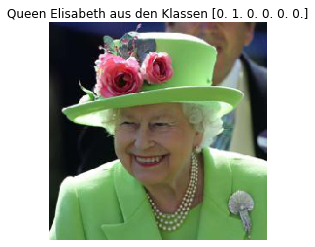

In [ ]:
item = train_generator.__getitem__(1) 
name = classes[np.argmax(item[1])] 
plt.imshow(np.squeeze(item[0]))
plt.title(f"{name} aus den Klassen {np.squeeze(item[1])}")
plt.axis('off')
plt.show()

In [ ]:
# Wir müssen ein paar Metaparameter für das Netzwerk definieren
num_classes = 6 # die Anzahl der Klassen die wir trainieren wollen
epochs = 10 # die Anzahl der Durchläufe des Models

In [ ]:
# Wir definieren als Basis-Model ein vortrainiertes Netzwerk. Hier nehmen wir ein MobileNetV2, da sich das bewehrt hat. 
# mit include_top = False schmeißen wir den letzten Layer weg!
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
# und wir müssen festlegen, dass die Gewichte in dem Netzwerk während des Trainings nicht angepasst werden
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# Wir definieren jetzt ein neues Model, was das Basis-Model und einen neuen letzten Layer verwendet
model = Sequential([
    base_model,     
    Conv2D(32, 3, activation='relu'),
    Dropout(0.2),
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])

In [ ]:
# Anschließend müssen wir das Netzwerk kompilieren mit:
# 1. Optimieren --> für das Korrigieren im Fehlerfall
# 2. Loss-Funktion --> zum Vergleich zwischen Vorhersage und tatsächlichem Label
# 3. Metrik --> zum Speichern des Verlaufs des Trainings

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,  # Trainingsdaten
    validation_data=validation_generator, # Validierungsdaten
    epochs=epochs # Durchläufe
)


Epoch 1/10
480/480 [==============================] - 230s 411ms/step - loss: 1.6402 - accuracy: 0.3417 - val_loss: 1.3596 - val_accuracy: 0.4417
Epoch 2/10
480/480 [==============================] - 5s 11ms/step - loss: 0.9418 - accuracy: 0.6687 - val_loss: 1.0036 - val_accuracy: 0.7083
Epoch 3/10
480/480 [==============================] - 5s 11ms/step - loss: 0.4323 - accuracy: 0.8625 - val_loss: 0.8733 - val_accuracy: 0.7583
Epoch 4/10
480/480 [==============================] - 5s 11ms/step - loss: 0.2251 - accuracy: 0.9312 - val_loss: 0.8202 - val_accuracy: 0.8083
Epoch 5/10
480/480 [==============================] - 5s 11ms/step - loss: 0.0898 - accuracy: 0.9688 - val_loss: 0.6889 - val_accuracy: 0.8083
Epoch 6/10
480/480 [==============================] - 5s 11ms/step - loss: 0.0426 - accuracy: 0.9875 - val_loss: 0.6259 - val_accuracy: 0.8417
Epoch 7/10
480/480 [==============================] - 5s 11ms/step - loss: 0.0222 - accuracy: 0.9937 - val_loss: 0.9002 - val_accuracy: 0.8

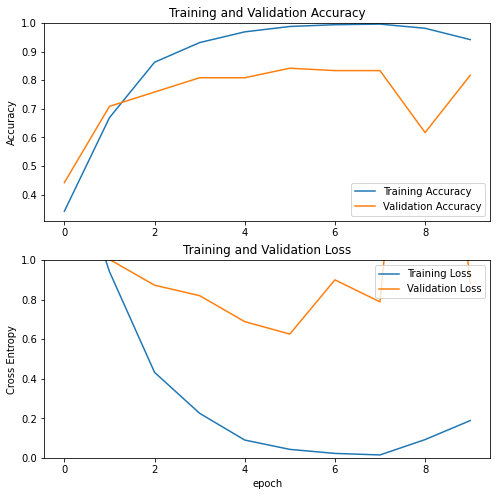

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Jetzt müssen wir das Model noch mal trainieren, und zwar mit dem Basis-Model zusammen
base_model.trainable = True

fine_tune_at = 100
# allerdings nur für die ersten 100 Layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [ ]:
history = model.fit(
        train_generator,  # Trainingsdaten
        validation_data=validation_generator, # Validierungsdaten
        epochs=5 # Durchläufe
    )

Epoch 1/5
480/480 [==============================] - 11s 17ms/step - loss: 1.3501 - accuracy: 0.4938 - val_loss: 3.8996 - val_accuracy: 0.5500
Epoch 2/5
480/480 [==============================] - 7s 15ms/step - loss: 0.3053 - accuracy: 0.9083 - val_loss: 3.5832 - val_accuracy: 0.5417
Epoch 3/5
480/480 [==============================] - 7s 15ms/step - loss: 0.1135 - accuracy: 0.9729 - val_loss: 2.7953 - val_accuracy: 0.6583
Epoch 4/5
480/480 [==============================] - 7s 15ms/step - loss: 0.0307 - accuracy: 0.9875 - val_loss: 1.7494 - val_accuracy: 0.7750
Epoch 5/5
480/480 [==============================] - 7s 16ms/step - loss: 0.0230 - accuracy: 0.9979 - val_loss: 1.1776 - val_accuracy: 0.8167


In [ ]:
# Speichert das Model ab, wenn ihr das Ergebnis gut findet
save_where = 'model.h5'
model.save_weights(save_where)